# Shoreline extraction at the benchmark sites with CoastSat


This notebook shows how to extract time-series of shoreline change at the 4 benchmark sites using the CoastSat toolbox.

## Initial settings

Refer to the **Installation** section of the [CoastSat README](https://github.com/kvos/CoastSat) for instructions on how to install the Python packages necessary to run the software, including Google Earth Engine Python API. If that step has been completed correctly, the following packages should be imported without any problem.

In [36]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.ion()
import pandas as pd
import geopandas as gpd
from datetime import datetime
import pytz

# load coastsat package located under algorithms/COASTSAT/
from coastsat import SDS_download, SDS_preprocess, SDS_shoreline, SDS_tools, SDS_transects

# filepaths to all the datasets
fp_datasets = os.path.join(os.path.join(os.pardir,os.pardir,'datasets'))
names_datasets = os.listdir(fp_datasets)

print('\nBenchmark datasets available:\n%s'%(names_datasets))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

Benchmark datasets available:
['DUCK', 'NARRABEEN', 'README.md', 'TORREYPINES', 'TRUCVERT']


## 1. Retrieval of the images from GEE

Here we download all the Landsat images between 1984 and 2022 for the benchmark sites using the provided ROIs.

In [2]:
# satellites to include
sat_list = ['L5','L7','L8','S2']
# choose Landsat collection 'C01' or 'C02'
landsat_collection = 'C02'
# dates
dates = ['1984-01-01', '2022-01-01']
# folder to save the images in
fp_images = os.path.join(os.pardir,'satellite_data')
# loop over each site
for sitename in names_datasets:
    print(sitename)
    data_folder = os.path.join(fp_datasets,sitename)
    # load polygon ROI
    fn_polygon = os.path.join(data_folder, '%s_polygon.geojson'%sitename)
    gdf_polygon = gpd.read_file(fn_polygon)
    polygon = np.array(gdf_polygon.loc[0,'geometry'].exterior.coords)
    # create inputs dictionary
    inputs = {}
    inputs['sitename'] = sitename
    inputs['polygon'] = [[[_[0], _[1]] for _ in polygon]]
    inputs['sat_list'] = sat_list
    inputs['dates'] = dates
    inputs['landsat_collection'] = landsat_collection
    inputs['filepath'] = fp_images
    if os.path.exists(os.path.join(fp_images,sitename,sitename+'_metadata.pkl')): continue
    # download the imagery
    metadata = SDS_download.retrieve_images(inputs)

DUCK
Number of images available between 1984-01-01 and 2022-01-01:
- In Landsat Tier 1 & Sentinel-2 Level-1C:
     L5: 659 images
     L7: 719 images
     L8: 163 images
     S2: 580 images
  Total to download: 2121 images
- In Landsat Tier 2 (not suitable for time-series analysis):
     L5: 151 images
     L7: 114 images
     L8: 10 images
  Total Tier 2: 275 images

L5: 659 images
100%
L7: 719 images
100%
L8: 163 images
100%
S2: 580 images
100%
Satellite images downloaded from GEE and save in ..\satellite_data\DUCK
NARRABEEN
Number of images available between 1984-01-01 and 2022-01-01:
- In Landsat Tier 1 & Sentinel-2 Level-1C:
     L5: 338 images
     L7: 464 images
     L8: 339 images
     S2: 619 images
  Total to download: 1760 images
- In Landsat Tier 2 (not suitable for time-series analysis):
     L5: 32 images
     L7: 39 images
     L8: 38 images
  Total Tier 2: 109 images

L5: 338 images
100%
L7: 464 images
100%
L8: 339 images
100%
S2: 619 images
100%
Satellite images downlo

**If you have already retrieved the images**, just load the metadata file for each site by running the section below

In [7]:
# loop over each site (for the moment only NARRABEEN)
sitename = 'NARRABEEN'
inputs = {}
inputs['sitename'] = sitename
inputs['filepath'] =  os.path.join(os.getcwd(),'satellite_data')
inputs['landsat_collection'] = 'C02'
inputs['dates'] =  ['1984-01-01', '2022-01-01']
inputs['sat_list'] = ['L5','L7','L8','S2']

metadata = SDS_download.get_metadata(inputs) 

## 2. Shoreline extraction

This section maps the position of the shoreline on the satellite images in a fully automated way (no manual quality-control). The images with the mapped shorelines are saved under `satellite_data\SITENAME\jpg_files`.

In [8]:
# settings for the shoreline extraction
settings = {
    # general parameters:
    'cloud_thresh': 0.1,        # threshold on maximum cloud cover
    'dist_clouds': 300,         # ditance around clouds where shoreline can't be mapped
    'output_epsg': 28356,       # epsg code of spatial reference system desired for the output
    # quality control:
    'check_detection': False,    # if True, shows each shoreline detection to the user for validation
    'adjust_detection': False,  # if True, allows user to adjust the postion of each shoreline by changing the threhold
    'save_figure': False,        # if True, saves a figure showing the mapped shoreline for each image
    # [ONLY FOR ADVANCED USERS] shoreline detection parameters:
    'min_beach_area': 1000,     # minimum area (in metres^2) for an object to be labelled as a beach
    'min_length_sl': 500,       # minimum length (in metres) of shoreline perimeter to be valid
    'cloud_mask_issue': False,  # switch this parameter to True if sand pixels are masked (in black) on many images
    'sand_color': 'default',    # 'default', 'latest', 'dark' (for grey/black sand beaches) or 'bright' (for white sand beaches)
    'pan_off': False,           # True to switch pansharpening off for Landsat 7/8/9 imagery
    # add the inputs defined previously
    'inputs': inputs,
}

# load the reference shoreline
data_folder = os.path.join(fp_datasets,sitename)
fn_refsl = os.path.join(data_folder, '%s_reference_shoreline.geojson'%sitename)
gdf_refsl = gpd.read_file(fn_refsl)
print('Loaded reference shoreline in epsg:%d'%gdf_refsl.crs.to_epsg())
gdf_refsl.to_crs(epsg=settings['output_epsg'], inplace=True)
print('Converted to epsg:%d'%gdf_refsl.crs.to_epsg())
refsl = np.array(gdf_refsl.loc[0,'geometry'].coords)
settings['reference_shoreline'] = refsl
# set the max distance (in meters) allowed from the reference shoreline for a detected shoreline to be valid
settings['max_dist_ref'] = 100

# extract shorelines from all images (also saves output.pkl and shorelines.geojson)
settings['save_figure'] = True
output = SDS_shoreline.extract_shorelines(metadata, settings)

Loaded reference shoreline in epsg:4326
Converted to epsg:28356
Mapping shorelines:
L5:   60%Could not map shoreline for this image: 1999-06-24-23-21-58_L5_NARRABEEN_ms.tif
L5:   100%
L7:   100%
L8:   100%
S2:   31%Could not map shoreline for this image: 2018-08-13-00-02-34_S2_NARRABEEN_ms.tif
S2:   31%Could not map shoreline for this image: 2018-08-13-00-05-52_S2_NARRABEEN_ms.tif
S2:   100%


The main output is `SITENAME_output.pkl` and contains the shorelines mapped and metadata.

An additional geospatial layer can also be created to visualise in a GIS environment with the code below.

In [15]:
# remove duplicates (images taken on the same date by the same satellite)
output = SDS_tools.remove_duplicates(output)
# remove inaccurate georeferencing (set threshold to 10 m)
output = SDS_tools.remove_inaccurate_georef(output, 10)

# for GIS applications, save output into a GEOJSON layer
geomtype = 'points' # choose 'points' or 'lines' for the layer geometry
gdf = SDS_tools.output_to_gdf(output, geomtype)
if gdf is None:
    raise Exception("output does not contain any mapped shorelines")
gdf.crs = {'init':'epsg:'+str(settings['output_epsg'])} # set layer projection
# save GEOJSON layer to file
gdf.to_file(os.path.join(inputs['filepath'], inputs['sitename'], '%s_output_%s.geojson'%(sitename,geomtype)),
                                driver='GeoJSON', encoding='utf-8')

## 3. Shoreline analysis

In this section we show how to compute time-series of cross-shore distance along user-defined shore-normal transects.

First load the mapped shoreline and the transects.

105 duplicates
5 bad georef
Loaded transects in epsg:4326
Converted to epsg:28356


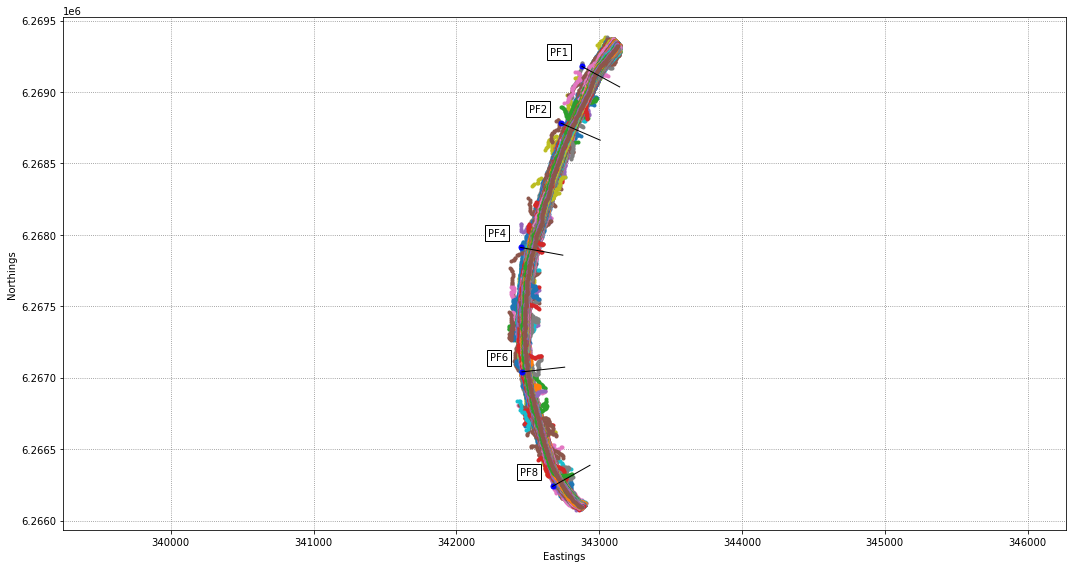

In [17]:
filepath = os.path.join(inputs['filepath'], sitename)
with open(os.path.join(filepath, sitename + '_output' + '.pkl'), 'rb') as f:
    output = pickle.load(f)
# remove duplicates (images taken on the same date by the same satellite)
output = SDS_tools.remove_duplicates(output)
# remove inaccurate georeferencing (set threshold to 10 m)
output = SDS_tools.remove_inaccurate_georef(output, 10)

# load transects
fn_transects = os.path.join(data_folder, '%s_transects.geojson'%sitename)
gdf_transects = gpd.read_file(fn_transects)
print('Loaded transects in epsg:%d'%gdf_transects.crs.to_epsg())
gdf_transects.to_crs(epsg=settings['output_epsg'], inplace=True)
print('Converted to epsg:%d'%gdf_transects.crs.to_epsg())
# put transects into a dictionary with their name
transects = dict([])
for i in gdf_transects.index:
    transects[gdf_transects.loc[i,'name']] = np.array(gdf_transects.loc[i,'geometry'].coords)

# plot the transects to make sure they are correct (origin landwards!)
fig = plt.figure(figsize=[15,8], tight_layout=True)
plt.axis('equal')
plt.xlabel('Eastings')
plt.ylabel('Northings')
plt.grid(linestyle=':', color='0.5')
for i in range(len(output['shorelines'])):
    sl = output['shorelines'][i]
    date = output['dates'][i]
    plt.plot(sl[:,0], sl[:,1], '.', label=date.strftime('%d-%m-%Y'))
for i,key in enumerate(list(transects.keys())):
    plt.plot(transects[key][0,0],transects[key][0,1], 'bo', ms=5)
    plt.plot(transects[key][:,0],transects[key][:,1],'k-',lw=1)
    plt.text(transects[key][0,0]-100, transects[key][0,1]+100, key,
                va='center', ha='right', bbox=dict(boxstyle="square", ec='k',fc='w'))
fig.savefig(os.path.join(inputs['filepath'], inputs['sitename'], 'mapped_shorelines.jpg'),dpi=200)

Compute intersections between shorelines and transects using the quality-controlled function.

In [40]:
settings_transects = { # parameters for computing intersections
                      'along_dist':          25,        # along-shore distance to use for computing the intersection
                      'min_points':          3,         # minimum number of shoreline points to calculate an intersection
                      'max_std':             15,        # max std for points around transect
                      'max_range':           30,        # max range for points around transect
                      'min_chainage':        -100,      # largest negative value along transect (landwards of transect origin)
                      'multiple_inter':      'auto',    # mode for removing outliers ('auto', 'nan', 'max')
                      'prc_multiple':         0.1,      # percentage of the time that multiple intersects are present to use the max
                     }
cross_distance = SDS_transects.compute_intersection_QC(output, transects, settings_transects) 
# remove outliers in the time-series (despiking)
settings_outliers = {'otsu_threshold':     [-.5,0],        # min and max intensity threshold use for contouring the shoreline
                     'max_cross_change':   40,             # maximum cross-shore change observable between consecutive timesteps
                     'plot_fig':           False,           # whether to plot the intermediate steps
                    }
cross_distance = SDS_transects.reject_outliers(cross_distance,output,settings_outliers)

In [41]:
# save a .csv file for each transect for submission
for key in transects.keys():
    out_dict = dict([])
    out_dict['dates'] = output['dates']
    out_dict[key] = cross_distance[key]
    out_dict['satname'] = output['satname']
    df = pd.DataFrame(out_dict)
    df.index=df['dates']
    df.pop('dates')
    fn = os.path.join(settings['inputs']['filepath'],settings['inputs']['sitename'],
                      '%s_timeseries_raw.csv'%key)
    df.to_csv(fn, sep=',')
    print('saved: %s'%fn)

saved: C:\Users\z5030440\Documents\SDS_Benchmark\algorithms\COASTSAT\satellite_data\NARRABEEN\PF1_timeseries_raw.csv
saved: C:\Users\z5030440\Documents\SDS_Benchmark\algorithms\COASTSAT\satellite_data\NARRABEEN\PF2_timeseries_raw.csv
saved: C:\Users\z5030440\Documents\SDS_Benchmark\algorithms\COASTSAT\satellite_data\NARRABEEN\PF4_timeseries_raw.csv
saved: C:\Users\z5030440\Documents\SDS_Benchmark\algorithms\COASTSAT\satellite_data\NARRABEEN\PF6_timeseries_raw.csv
saved: C:\Users\z5030440\Documents\SDS_Benchmark\algorithms\COASTSAT\satellite_data\NARRABEEN\PF8_timeseries_raw.csv


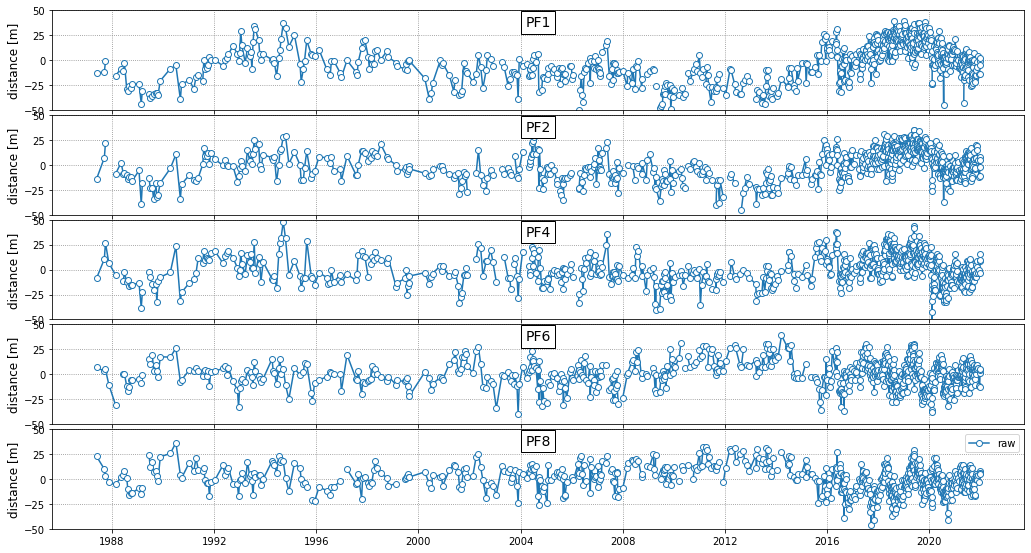

In [42]:
# plot the time-series of shoreline change (both raw and tidally-corrected)
fig = plt.figure(figsize=[15,8], tight_layout=True)
gs = gridspec.GridSpec(len(cross_distance),1)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.05)
for i,key in enumerate(cross_distance.keys()):
    if np.all(np.isnan(cross_distance[key])):
        continue
    ax = fig.add_subplot(gs[i,0])
    ax.grid(linestyle=':', color='0.5')
    ax.set_ylim([-50,50])
    ax.plot(output['dates'], cross_distance[key]- np.nanmedian(cross_distance[key]), '-o', ms=6, mfc='w', label='raw')
    ax.set_ylabel('distance [m]', fontsize=12)
    ax.text(0.5,0.95, key, bbox=dict(boxstyle="square", ec='k',fc='w'), ha='center',
            va='top', transform=ax.transAxes, fontsize=14)
ax.legend();

Apply tidal correction and save tidally-corrected time-series of shoreline change

Extracting closest points: 100%

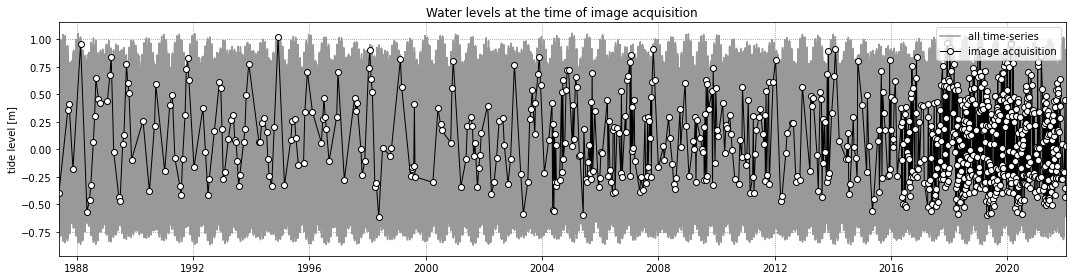

In [43]:
# load tide time-series
fn_tides = os.path.join(data_folder,'%s_tides.csv'%sitename)
tide_data = pd.read_csv(fn_tides, parse_dates=['dates'])
dates_ts = [pytz.utc.localize(_.to_pydatetime()) for _ in tide_data['dates']]
tides_ts = np.array(tide_data['tides'])

# get tide levels corresponding to the time of image acquisition
dates_sat = output['dates']
tides_sat = SDS_tools.get_closest_datapoint(dates_sat, dates_ts, tides_ts)

# plot the subsampled tide data
fig, ax = plt.subplots(1,1,figsize=(15,4), tight_layout=True)
ax.grid(which='major', linestyle=':', color='0.5')
ax.plot(tide_data['dates'], tide_data['tides'], '-', color='0.6', label='all time-series')
ax.plot(dates_sat, tides_sat, '-o', color='k', ms=6, mfc='w',lw=1, label='image acquisition')
ax.set(ylabel='tide level [m]',xlim=[dates_sat[0],dates_sat[-1]], title='Water levels at the time of image acquisition')
ax.legend()

# tidal correction along each transect
reference_elevation = 0.7 # elevation at which you would like the shoreline time-series to be
beach_slope = 0.1
cross_distance_tidally_corrected = {}
for key in cross_distance.keys():
    correction = (tides_sat-reference_elevation)/beach_slope
    cross_distance_tidally_corrected[key] = cross_distance[key] + correction

In [44]:
# save a .csv file for each transect for submission
for key in transects.keys():
    out_dict = dict([])
    out_dict['dates'] = output['dates']
    out_dict[key] = cross_distance_tidally_corrected[key]
    out_dict['satname'] = output['satname']
    df = pd.DataFrame(out_dict)
    df.index=df['dates']
    df.pop('dates')
    fn = os.path.join(settings['inputs']['filepath'],settings['inputs']['sitename'],
                      '%s_timeseries_tidally_corrected.csv'%key)
    df.to_csv(fn, sep=',')
    print('saved: %s'%fn)

saved: C:\Users\z5030440\Documents\SDS_Benchmark\algorithms\COASTSAT\satellite_data\NARRABEEN\PF1_timeseries_tidally_corrected.csv
saved: C:\Users\z5030440\Documents\SDS_Benchmark\algorithms\COASTSAT\satellite_data\NARRABEEN\PF2_timeseries_tidally_corrected.csv
saved: C:\Users\z5030440\Documents\SDS_Benchmark\algorithms\COASTSAT\satellite_data\NARRABEEN\PF4_timeseries_tidally_corrected.csv
saved: C:\Users\z5030440\Documents\SDS_Benchmark\algorithms\COASTSAT\satellite_data\NARRABEEN\PF6_timeseries_tidally_corrected.csv
saved: C:\Users\z5030440\Documents\SDS_Benchmark\algorithms\COASTSAT\satellite_data\NARRABEEN\PF8_timeseries_tidally_corrected.csv


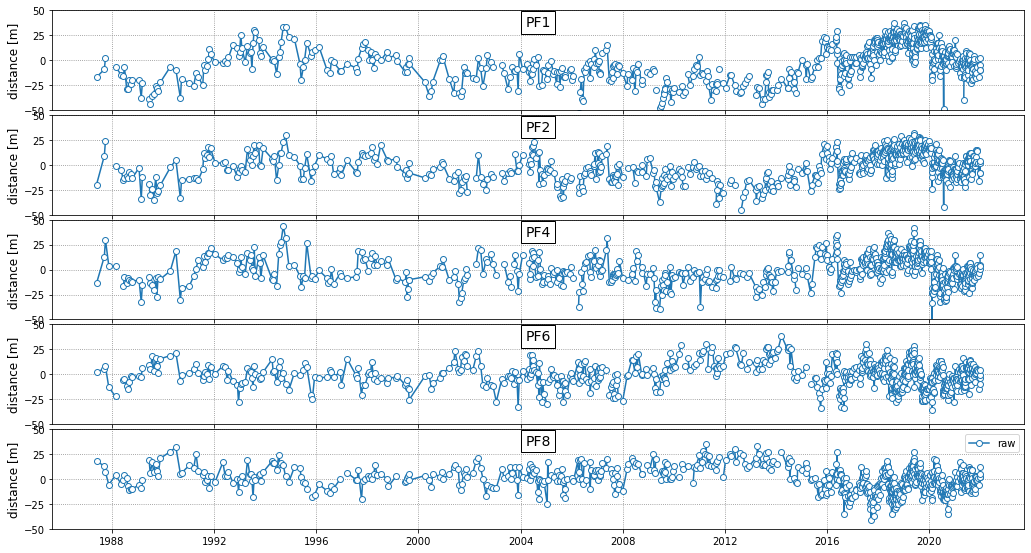

In [45]:
# plot the time-series of shoreline change (both raw and tidally-corrected)
fig = plt.figure(figsize=[15,8], tight_layout=True)
gs = gridspec.GridSpec(len(cross_distance),1)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.05)
for i,key in enumerate(cross_distance_tidally_corrected.keys()):
    if np.all(np.isnan(cross_distance_tidally_corrected[key])):
        continue
    ax = fig.add_subplot(gs[i,0])
    ax.grid(linestyle=':', color='0.5')
    ax.set_ylim([-50,50])
    ax.plot(output['dates'], cross_distance_tidally_corrected[key]- np.nanmedian(cross_distance_tidally_corrected[key]), '-o', ms=6, mfc='w', label='raw')
    ax.set_ylabel('distance [m]', fontsize=12)
    ax.text(0.5,0.95, key, bbox=dict(boxstyle="square", ec='k',fc='w'), ha='center',
            va='top', transform=ax.transAxes, fontsize=14)
ax.legend();